In [6]:
import time
import sys
import os
import math
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import CellModeller

#### Funcs

In [2]:
# continuous model
def step(p1, p2, p3, gamma, mu, d, e, n, Dt):
    # Update protein concs
    nextp1 = p1 + ((d + e*(p3**n))/(1 + p3**n) - gamma*p1 - mu*p1) * Dt
    nextp2 = p2 + ((d + e*(p1**n))/(1 + p1**n) - gamma*p2 - mu*p2) * Dt
    nextp3 = p3 + ((d + e*(p2**n))/(1 + p2**n) - gamma*p3 - mu*p3) * Dt
    return nextp1, nextp2, nextp3

In [3]:
# Gillespie's

#### Build lineage's graph from last pickle

In [4]:
# using Deg03 to check correct values of 
path = '../Data/'
model = 'simpleGrowth10/'
files = os.listdir(path+model)
files.sort()
# not using module (think on removing it)
files = files[1:]

In [5]:
# get last pickle's lineage
last_pickle = pickle.load(open(path+model+files[-1], 'rb'))

In [6]:
# constructing data
lin = last_pickle['lineage']
nodes = list(lin.keys())
edges = [(v,k) for k,v in lin.items()]

In [7]:
# create directed graph
G = nx.DiGraph()
# add cell's ids as nodes
G.add_node(1)
G.add_nodes_from(nodes)
# add (parent_id, child_id) tuples as edges
G.add_edges_from(edges)

In [8]:
# just testing
list(G.successors(1))

[2, 3]

### Loop over pickles

#### Sim params

In [9]:
# Continuous model params
Dt = 0.05
#gamma = 0.3
#d = 198.
e = 0
n = 2
init_conds = [0, 0, 5.0]

# Sim params
pickeSteps = 1
#time between pickles 
p_time = Dt*pickeSteps #hours
#store_folder = path+model[:-1]+'SIM2/'

In [13]:
#gammas = [0.5, 0.7, 1.2, 1.5]#np.logspace(-2, 0, 5, endpoint=True)
#ds = np.logspace(2, 6, 5, endpoint=True)
gammas = np.append(np.logspace(-2, 0, 5, endpoint=True) , np.array([0.5, 0.7, 1.2, 1.5]), axis=0)
gammas.sort()
ds = [10000.0]

In [23]:
ds = np.logspace(2, 6, 5, endpoint=True)
ds

array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])

In [21]:
gammas

array([0.01      , 0.03162278, 0.1       , 0.31622777, 0.5       ,
       0.7       , 1.        , 1.2       , 1.5       ])

In [15]:
files = []
for gamma in gammas:
    for d in ds:
        files.append(f"data_contSIM_{str(gamma)}_{str(d)}.json")

files

['data_contSIM_0.01_10000.0.json',
 'data_contSIM_0.03162277660168379_10000.0.json',
 'data_contSIM_0.1_10000.0.json',
 'data_contSIM_0.31622776601683794_10000.0.json',
 'data_contSIM_0.5_10000.0.json',
 'data_contSIM_0.7_10000.0.json',
 'data_contSIM_1.0_10000.0.json',
 'data_contSIM_1.2_10000.0.json',
 'data_contSIM_1.5_10000.0.json']

In [11]:
# database file structure
"""
database = 
{
    'it': {
        'cell_id1':
        {'pos': [x, y, z], 'fluo': [p1, p2, p3], 'growthRate': gr},
        'cell_id2':
        {'pos': [x, y, z], 'fluo': [p1, p2, p3], 'growthRate': gr},
        ...
    },
}
"""

"\ndatabase = \n{\n    'it': {\n        'cell_id1':\n        {'pos': [x, y, z], 'fluo': [p1, p2, p3], 'growthRate': gr},\n        'cell_id2':\n        {'pos': [x, y, z], 'fluo': [p1, p2, p3], 'growthRate': gr},\n        ...\n    },\n}\n"

### loop

In [ ]:
for gamma in gammas[1:]:
    for d in ds:      
        # Initialize pickle 0 with desired initial conditions
        pickle_0 = pickle.load(open(path+model+'step-00000.pickle', 'rb'))
        pickle_0['cellStates'][1].color = init_conds
        pos = pickle_0['cellStates'][1].pos
        pos = [float(i) for i in pos]
        gr = pickle_0['cellStates'][1].strainRate / Dt

        database = {}
        database[0] = {1: {'pos': pos, 'fluo': init_conds}, 'growthRate': float(gr)}

        #for idx in range(1, len(files)):
        startproc = time.time()
        for idx in range(1, len(files)):
            #print("######################################################")
            print(f"gamma={gamma}, d={d}, idx: {idx}")
            #startwhole = time.time()
            # get pickles lineage
            # this pickle needs to have concs, so get it from pickle save past iteration
            # Create new key in database:
            database[idx] = {}
            # previous step, stored in database file
            data1 = database[idx-1]
            # current step, stored in pickle file from CM
            data2 = pickle.load(open(path+model+files[idx], 'rb'))

            #print(f"Number of cells: {len(data2['cellStates'].keys())}")
            if len(data2['cellStates'].keys()) > 60000:
                break

            # need to identify which cells divided from one pickle to the next
            # cells present in step 2 but not in 1 (children)
            not_in_prev = list(set(data2['cellStates'].keys()) - set(data1.keys()))

            # cell division
            if len(not_in_prev) > 0:
                # cells in 1 and not in 2 (parents)
                not_in_curr = list(set(data1.keys()) - set(data2['cellStates'].keys()))
                # each cell in not_in_curr (parents)
                for par_cell in not_in_curr:       
                    succ = list(G.successors(par_cell))

                    # create new entries for children in database file
                    database[idx][succ[0]] = {}
                    database[idx][succ[1]] = {}

                    # Update children state based on parent's state
                    # 1) update parent's concentrations from step 1 to 2, to be inherited updated
                    par_conc_old = data1[par_cell]['fluo']
                    p1, p2, p3 = par_conc_old[0], par_conc_old[1], par_conc_old[2]
                    mu = data1[par_cell]['growthRate']
                    nextp1, nextp2, nextp3 = step(p1, p2, p3, gamma, mu, d, e, n, Dt) 

                    # 2) inherit concentration from parent: assign pos, conc, growthRate to each child
                    concs_1 = [nextp1, nextp2, nextp3]
                    new_conc = np.array(concs_1)
                    # Assign pos            
                    # Needs to convert from numpy.float32 to float
                    database[idx][succ[0]]['pos'] = [float(p) for p in data2['cellStates'][succ[0]].pos]
                    database[idx][succ[1]]['pos'] = [float(p) for p in data2['cellStates'][succ[1]].pos]

                    # Assign species conc
                    database[idx][succ[0]]['fluo'] = new_conc.tolist()
                    database[idx][succ[1]]['fluo'] = new_conc.tolist()

                    # Assign growth rate
                    database[idx][succ[0]]['growthRate'] = mu 
                    database[idx][succ[1]]['growthRate'] = mu

                    # cells remaining in not_in_prev obj
                    new_left = list(set(not_in_prev) - set(succ))

                    # update not_in_prev
                    not_in_prev = new_left

            # no cell division
            else:
                pass

            ##################################
            # RUN CONTINUOUS OR GILLESPIE SIM
            ##################################

            # this is for cells that did't get divided
            #step(p1, p2, p3, gamma, mu, d, e, n, Dt)

            cells_both = list(set(data2['cellStates'].keys()) & set(data1.keys()))
            #start = time.time()
            # FOR EACH CELL
            for c in cells_both:
                database[idx][c] = {}
                # calculate concentrations
                pos_2 = [float(p) for p in data2['cellStates'][c].pos]
                concs = data1[c]['fluo']

                p1, p2, p3 = concs[0], concs[1], concs[2]
                mu = float(data2['cellStates'][c].strainRate / Dt)
                nextp1, nextp2, nextp3 = step(p1, p2, p3, gamma, mu, d, e, n, Dt)

                # assign to next pickle
                database[idx][c]['pos'] = pos_2
                database[idx][c]['fluo'] = [nextp1, nextp2, nextp3]
                database[idx][c]['growthRate'] = mu

            #end = time.time()
            #print(f"SIM: {end-start} secs")
            # STORE PICKLE WITH NEW CONCS
                ## Send picke2 (data2) to be read and stored
            # needs to have all concs updated

            #endwhole = time.time()
            #print(f"Time taken: {endwhole-startwhole}")

        endproc = time.time()
        print(f"Whole process gamma={gamma}, d={d} took {endproc-startproc} secs")

        start = time.time()
        print("Storing file")
        with open(f"SIMS/data_contSIM_{str(gamma)}_{str(d)}.json", 'w') as outfile:  
            json.dump(database, outfile)
        end = time.time()
        print(f"saving gamma={gamma}, d={d} took {end-start} secs")

idx:  1
idx:  2
idx:  3
idx:  4
idx:  5
idx:  6
idx:  7
idx:  8
idx:  9
idx:  10
idx:  11
idx:  12
idx:  13
idx:  14
idx:  15
idx:  16
idx:  17
idx:  18
idx:  19
idx:  20
idx:  21
idx:  22
idx:  23
idx:  24
idx:  25
idx:  26
idx:  27
idx:  28
idx:  29
idx:  30
idx:  31
idx:  32
idx:  33
idx:  34
idx:  35
idx:  36
idx:  37
idx:  38
idx:  39
idx:  40
idx:  41
idx:  42
idx:  43
idx:  44
idx:  45
idx:  46
idx:  47
idx:  48
idx:  49
idx:  50
idx:  51
idx:  52
idx:  53
idx:  54
idx:  55
idx:  56
idx:  57
idx:  58
idx:  59
idx:  60
idx:  61
idx:  62
idx:  63
idx:  64
idx:  65
idx:  66
idx:  67
idx:  68
idx:  69
idx:  70
idx:  71
idx:  72
idx:  73
idx:  74
idx:  75
idx:  76
idx:  77
idx:  78
idx:  79
idx:  80
idx:  81
idx:  82
idx:  83
idx:  84
idx:  85
idx:  86
idx:  87
idx:  88
idx:  89
idx:  90
idx:  91
idx:  92
idx:  93
idx:  94
idx:  95
idx:  96
idx:  97
idx:  98
idx:  99
idx:  100
idx:  101
idx:  102
idx:  103
idx:  104
idx:  105
idx:  106
idx:  107
idx:  108
idx:  109
idx:  110
idx:  11

idx:  832
idx:  833
idx:  834
idx:  835
idx:  836
idx:  837
idx:  838
idx:  839
idx:  840
idx:  841
idx:  842
idx:  843
idx:  844
idx:  845
idx:  846
idx:  847
idx:  848
idx:  849
idx:  850
idx:  851
idx:  852
idx:  853
idx:  854
idx:  855
idx:  856
idx:  857
idx:  858
idx:  859
idx:  860
idx:  861
idx:  862
idx:  863
idx:  864
idx:  865
idx:  866
idx:  867
idx:  868
idx:  869
idx:  870
idx:  871
idx:  872
idx:  873
idx:  874
idx:  875
idx:  876
idx:  877
idx:  878
idx:  879
idx:  880
idx:  881
idx:  882
idx:  883
idx:  884
idx:  885
idx:  886
idx:  887
idx:  888
idx:  889
idx:  890
idx:  891
idx:  892
idx:  893
idx:  894
idx:  895
idx:  896
idx:  897
idx:  898
idx:  899
idx:  900
idx:  901
idx:  902
idx:  903
idx:  904
idx:  905
idx:  906
idx:  907
idx:  908
idx:  909
idx:  910
idx:  911
idx:  912
idx:  913
idx:  914
idx:  915
idx:  916
idx:  917
idx:  918
idx:  919
idx:  920
idx:  921
idx:  922
idx:  923
idx:  924
idx:  925
idx:  926
idx:  927
idx:  928
idx:  929
idx:  930
idx:  931


idx:  621
idx:  622
idx:  623
idx:  624
idx:  625
idx:  626
idx:  627
idx:  628
idx:  629
idx:  630
idx:  631
idx:  632
idx:  633
idx:  634
idx:  635
idx:  636
idx:  637
idx:  638
idx:  639
idx:  640
idx:  641
idx:  642
idx:  643
idx:  644
idx:  645
idx:  646
idx:  647
idx:  648
idx:  649
idx:  650
idx:  651
idx:  652
idx:  653
idx:  654
idx:  655
idx:  656
idx:  657
idx:  658
idx:  659
idx:  660
idx:  661
idx:  662
idx:  663
idx:  664
idx:  665
idx:  666
idx:  667
idx:  668
idx:  669
idx:  670
idx:  671
idx:  672
idx:  673
idx:  674
idx:  675
idx:  676
idx:  677
idx:  678
idx:  679
idx:  680
idx:  681
idx:  682
idx:  683
idx:  684
idx:  685
idx:  686
idx:  687
idx:  688
idx:  689
idx:  690
idx:  691
idx:  692
idx:  693
idx:  694
idx:  695
idx:  696
idx:  697
idx:  698
idx:  699
idx:  700
idx:  701
idx:  702
idx:  703
idx:  704
idx:  705
idx:  706
idx:  707
idx:  708
idx:  709
idx:  710
idx:  711
idx:  712
idx:  713
idx:  714
idx:  715
idx:  716
idx:  717
idx:  718
idx:  719
idx:  720


idx:  408
idx:  409
idx:  410
idx:  411
idx:  412
idx:  413
idx:  414
idx:  415
idx:  416
idx:  417
idx:  418
idx:  419
idx:  420
idx:  421
idx:  422
idx:  423
idx:  424
idx:  425
idx:  426
idx:  427
idx:  428
idx:  429
idx:  430
idx:  431
idx:  432
idx:  433
idx:  434
idx:  435
idx:  436
idx:  437
idx:  438
idx:  439
idx:  440
idx:  441
idx:  442
idx:  443
idx:  444
idx:  445
idx:  446
idx:  447
idx:  448
idx:  449
idx:  450
idx:  451
idx:  452
idx:  453
idx:  454
idx:  455
idx:  456
idx:  457
idx:  458
idx:  459
idx:  460
idx:  461
idx:  462
idx:  463
idx:  464
idx:  465
idx:  466
idx:  467
idx:  468
idx:  469
idx:  470
idx:  471
idx:  472
idx:  473
idx:  474
idx:  475
idx:  476
idx:  477
idx:  478
idx:  479
idx:  480
idx:  481
idx:  482
idx:  483
idx:  484
idx:  485
idx:  486
idx:  487
idx:  488
idx:  489
idx:  490
idx:  491
idx:  492
idx:  493
idx:  494
idx:  495
idx:  496
idx:  497
idx:  498
idx:  499
idx:  500
idx:  501
idx:  502
idx:  503
idx:  504
idx:  505
idx:  506
idx:  507


idx:  199
idx:  200
idx:  201
idx:  202
idx:  203
idx:  204
idx:  205
idx:  206
idx:  207
idx:  208
idx:  209
idx:  210
idx:  211
idx:  212
idx:  213
idx:  214
idx:  215
idx:  216
idx:  217
idx:  218
idx:  219
idx:  220
idx:  221
idx:  222
idx:  223
idx:  224
idx:  225
idx:  226
idx:  227
idx:  228
idx:  229
idx:  230
idx:  231
idx:  232
idx:  233
idx:  234
idx:  235
idx:  236
idx:  237
idx:  238
idx:  239
idx:  240
idx:  241
idx:  242
idx:  243
idx:  244
idx:  245
idx:  246
idx:  247
idx:  248
idx:  249
idx:  250
idx:  251
idx:  252
idx:  253
idx:  254
idx:  255
idx:  256
idx:  257
idx:  258
idx:  259
idx:  260
idx:  261
idx:  262
idx:  263
idx:  264
idx:  265
idx:  266
idx:  267
idx:  268
idx:  269
idx:  270
idx:  271
idx:  272
idx:  273
idx:  274
idx:  275
idx:  276
idx:  277
idx:  278
idx:  279
idx:  280
idx:  281
idx:  282
idx:  283
idx:  284
idx:  285
idx:  286
idx:  287
idx:  288
idx:  289
idx:  290
idx:  291
idx:  292
idx:  293
idx:  294
idx:  295
idx:  296
idx:  297
idx:  298


idx:  1017
idx:  1018
idx:  1019
idx:  1020
idx:  1021
idx:  1022
idx:  1023
idx:  1024
idx:  1025
idx:  1026
Whole process gamma=0.01, d=2154.4346900318824 took 605.2373521327972 secs
Storing file
saving gamma=0.01, d=2154.4346900318824 took 299.9747123718262 secs
idx:  1
idx:  2
idx:  3
idx:  4
idx:  5
idx:  6
idx:  7
idx:  8
idx:  9
idx:  10
idx:  11
idx:  12
idx:  13
idx:  14
idx:  15
idx:  16
idx:  17
idx:  18
idx:  19
idx:  20
idx:  21
idx:  22
idx:  23
idx:  24
idx:  25
idx:  26
idx:  27
idx:  28
idx:  29
idx:  30
idx:  31
idx:  32
idx:  33
idx:  34
idx:  35
idx:  36
idx:  37
idx:  38
idx:  39
idx:  40
idx:  41
idx:  42
idx:  43
idx:  44
idx:  45
idx:  46
idx:  47
idx:  48
idx:  49
idx:  50
idx:  51
idx:  52
idx:  53
idx:  54
idx:  55
idx:  56
idx:  57
idx:  58
idx:  59
idx:  60
idx:  61
idx:  62
idx:  63
idx:  64
idx:  65
idx:  66
idx:  67
idx:  68
idx:  69
idx:  70
idx:  71
idx:  72
idx:  73
idx:  74
idx:  75
idx:  76
idx:  77
idx:  78
idx:  79
idx:  80
idx:  81
idx:  82
idx: 

idx:  805
idx:  806
idx:  807
idx:  808
idx:  809
idx:  810
idx:  811
idx:  812
idx:  813
idx:  814
idx:  815
idx:  816
idx:  817
idx:  818
idx:  819
idx:  820
idx:  821
idx:  822
idx:  823
idx:  824
idx:  825
idx:  826
idx:  827
idx:  828
idx:  829
idx:  830
idx:  831
idx:  832
idx:  833
idx:  834
idx:  835
idx:  836
idx:  837
idx:  838
idx:  839
idx:  840
idx:  841
idx:  842
idx:  843
idx:  844
idx:  845
idx:  846
idx:  847
idx:  848
idx:  849
idx:  850
idx:  851
idx:  852
idx:  853
idx:  854
idx:  855
idx:  856
idx:  857
idx:  858
idx:  859
idx:  860
idx:  861
idx:  862
idx:  863
idx:  864
idx:  865
idx:  866
idx:  867
idx:  868
idx:  869
idx:  870
idx:  871
idx:  872
idx:  873
idx:  874
idx:  875
idx:  876
idx:  877
idx:  878
idx:  879
idx:  880
idx:  881
idx:  882
idx:  883
idx:  884
idx:  885
idx:  886
idx:  887
idx:  888
idx:  889
idx:  890
idx:  891
idx:  892
idx:  893
idx:  894
idx:  895
idx:  896
idx:  897
idx:  898
idx:  899
idx:  900
idx:  901
idx:  902
idx:  903
idx:  904


idx:  591
idx:  592
idx:  593
idx:  594
idx:  595
idx:  596
idx:  597
idx:  598
idx:  599
idx:  600
idx:  601
idx:  602
idx:  603
idx:  604
idx:  605
idx:  606
idx:  607
idx:  608
idx:  609
idx:  610
idx:  611
idx:  612
idx:  613
idx:  614
idx:  615
idx:  616
idx:  617
idx:  618
idx:  619
idx:  620
idx:  621
idx:  622
idx:  623
idx:  624
idx:  625
idx:  626
idx:  627
idx:  628
idx:  629
idx:  630
idx:  631
idx:  632
idx:  633
idx:  634
idx:  635
idx:  636
idx:  637
idx:  638
idx:  639
idx:  640
idx:  641
idx:  642
idx:  643
idx:  644
idx:  645
idx:  646
idx:  647
idx:  648
idx:  649
idx:  650
idx:  651
idx:  652
idx:  653
idx:  654
idx:  655
idx:  656
idx:  657
idx:  658
idx:  659
idx:  660
idx:  661
idx:  662
idx:  663
idx:  664
idx:  665
idx:  666
idx:  667
idx:  668
idx:  669
idx:  670
idx:  671
idx:  672
idx:  673
idx:  674
idx:  675
idx:  676
idx:  677
idx:  678
idx:  679
idx:  680
idx:  681
idx:  682
idx:  683
idx:  684
idx:  685
idx:  686
idx:  687
idx:  688
idx:  689
idx:  690


idx:  377
idx:  378
idx:  379
idx:  380
idx:  381
idx:  382
idx:  383
idx:  384
idx:  385
idx:  386
idx:  387
idx:  388
idx:  389
idx:  390
idx:  391
idx:  392
idx:  393
idx:  394
idx:  395
idx:  396
idx:  397
idx:  398
idx:  399
idx:  400
idx:  401
idx:  402
idx:  403
idx:  404
idx:  405
idx:  406
idx:  407
idx:  408
idx:  409
idx:  410
idx:  411
idx:  412
idx:  413
idx:  414
idx:  415
idx:  416
idx:  417
idx:  418
idx:  419
idx:  420
idx:  421
idx:  422
idx:  423
idx:  424
idx:  425
idx:  426
idx:  427
idx:  428
idx:  429
idx:  430
idx:  431
idx:  432
idx:  433
idx:  434
idx:  435
idx:  436
idx:  437
idx:  438
idx:  439
idx:  440
idx:  441
idx:  442
idx:  443
idx:  444
idx:  445
idx:  446
idx:  447
idx:  448
idx:  449
idx:  450
idx:  451
idx:  452
idx:  453
idx:  454
idx:  455
idx:  456
idx:  457
idx:  458
idx:  459
idx:  460
idx:  461
idx:  462
idx:  463
idx:  464
idx:  465
idx:  466
idx:  467
idx:  468
idx:  469
idx:  470
idx:  471
idx:  472
idx:  473
idx:  474
idx:  475
idx:  476


idx:  169
idx:  170
idx:  171
idx:  172
idx:  173
idx:  174
idx:  175
idx:  176
idx:  177
idx:  178
idx:  179
idx:  180
idx:  181
idx:  182
idx:  183
idx:  184
idx:  185
idx:  186
idx:  187
idx:  188
idx:  189
idx:  190
idx:  191
idx:  192
idx:  193
idx:  194
idx:  195
idx:  196
idx:  197
idx:  198
idx:  199
idx:  200
idx:  201
idx:  202
idx:  203
idx:  204
idx:  205
idx:  206
idx:  207
idx:  208
idx:  209
idx:  210
idx:  211
idx:  212
idx:  213
idx:  214
idx:  215
idx:  216
idx:  217
idx:  218
idx:  219
idx:  220
idx:  221
idx:  222
idx:  223
idx:  224
idx:  225
idx:  226
idx:  227
idx:  228
idx:  229
idx:  230
idx:  231
idx:  232
idx:  233
idx:  234
idx:  235
idx:  236
idx:  237
idx:  238
idx:  239
idx:  240
idx:  241
idx:  242
idx:  243
idx:  244
idx:  245
idx:  246
idx:  247
idx:  248
idx:  249
idx:  250
idx:  251
idx:  252
idx:  253
idx:  254
idx:  255
idx:  256
idx:  257
idx:  258
idx:  259
idx:  260
idx:  261
idx:  262
idx:  263
idx:  264
idx:  265
idx:  266
idx:  267
idx:  268


idx:  989
idx:  990
idx:  991
idx:  992
idx:  993
idx:  994
idx:  995
idx:  996
idx:  997
idx:  998
idx:  999
idx:  1000
idx:  1001
idx:  1002
idx:  1003
idx:  1004
idx:  1005
idx:  1006
idx:  1007
idx:  1008
idx:  1009
idx:  1010
idx:  1011
idx:  1012
idx:  1013
idx:  1014
idx:  1015
idx:  1016
idx:  1017
idx:  1018
idx:  1019
idx:  1020
idx:  1021
idx:  1022
idx:  1023
idx:  1024
idx:  1025
idx:  1026
Whole process gamma=0.01, d=129154.96650148826 took 575.0995948314667 secs
Storing file
saving gamma=0.01, d=129154.96650148826 took 297.4717655181885 secs
idx:  1
idx:  2
idx:  3
idx:  4
idx:  5
idx:  6
idx:  7
idx:  8
idx:  9
idx:  10
idx:  11
idx:  12
idx:  13
idx:  14
idx:  15
idx:  16
idx:  17
idx:  18
idx:  19
idx:  20
idx:  21
idx:  22
idx:  23
idx:  24
idx:  25
idx:  26
idx:  27
idx:  28
idx:  29
idx:  30
idx:  31
idx:  32
idx:  33
idx:  34
idx:  35
idx:  36
idx:  37
idx:  38
idx:  39
idx:  40
idx:  41
idx:  42
idx:  43
idx:  44
idx:  45
idx:  46
idx:  47
idx:  48
idx:  49
idx: 

idx:  775
idx:  776
idx:  777
idx:  778
idx:  779
idx:  780
idx:  781
idx:  782
idx:  783
idx:  784
idx:  785
idx:  786
idx:  787
idx:  788
idx:  789
idx:  790
idx:  791
idx:  792
idx:  793
idx:  794
idx:  795
idx:  796
idx:  797
idx:  798
idx:  799
idx:  800
idx:  801
idx:  802
idx:  803
idx:  804
idx:  805
idx:  806
idx:  807
idx:  808
idx:  809
idx:  810
idx:  811
idx:  812
idx:  813
idx:  814
idx:  815
idx:  816
idx:  817
idx:  818
idx:  819
idx:  820
idx:  821
idx:  822
idx:  823
idx:  824
idx:  825
idx:  826
idx:  827
idx:  828
idx:  829
idx:  830
idx:  831
idx:  832
idx:  833
idx:  834
idx:  835
idx:  836
idx:  837
idx:  838
idx:  839
idx:  840
idx:  841
idx:  842
idx:  843
idx:  844
idx:  845
idx:  846
idx:  847
idx:  848
idx:  849
idx:  850
idx:  851
idx:  852
idx:  853
idx:  854
idx:  855
idx:  856
idx:  857
idx:  858
idx:  859
idx:  860
idx:  861
idx:  862
idx:  863
idx:  864
idx:  865
idx:  866
idx:  867
idx:  868
idx:  869
idx:  870
idx:  871
idx:  872
idx:  873
idx:  874


idx:  561
idx:  562
idx:  563
idx:  564
idx:  565
idx:  566
idx:  567
idx:  568
idx:  569
idx:  570
idx:  571
idx:  572
idx:  573
idx:  574
idx:  575
idx:  576
idx:  577
idx:  578
idx:  579
idx:  580
idx:  581
idx:  582
idx:  583
idx:  584
idx:  585
idx:  586
idx:  587
idx:  588
idx:  589
idx:  590
idx:  591
idx:  592
idx:  593
idx:  594
idx:  595
idx:  596
idx:  597
idx:  598
idx:  599
idx:  600
idx:  601
idx:  602
idx:  603
idx:  604
idx:  605
idx:  606
idx:  607
idx:  608
idx:  609
idx:  610
idx:  611
idx:  612
idx:  613
idx:  614
idx:  615
idx:  616
idx:  617
idx:  618
idx:  619
idx:  620
idx:  621
idx:  622
idx:  623
idx:  624
idx:  625
idx:  626
idx:  627
idx:  628
idx:  629
idx:  630
idx:  631
idx:  632
idx:  633
idx:  634
idx:  635
idx:  636
idx:  637
idx:  638
idx:  639
idx:  640
idx:  641
idx:  642
idx:  643
idx:  644
idx:  645
idx:  646
idx:  647
idx:  648
idx:  649
idx:  650
idx:  651
idx:  652
idx:  653
idx:  654
idx:  655
idx:  656
idx:  657
idx:  658
idx:  659
idx:  660


idx:  349
idx:  350
idx:  351
idx:  352
idx:  353
idx:  354
idx:  355
idx:  356
idx:  357
idx:  358
idx:  359
idx:  360
idx:  361
idx:  362
idx:  363
idx:  364
idx:  365
idx:  366
idx:  367
idx:  368
idx:  369
idx:  370
idx:  371
idx:  372
idx:  373
idx:  374
idx:  375
idx:  376
idx:  377
idx:  378
idx:  379
idx:  380
idx:  381
idx:  382
idx:  383
idx:  384
idx:  385
idx:  386
idx:  387
idx:  388
idx:  389
idx:  390
idx:  391
idx:  392
idx:  393
idx:  394
idx:  395
idx:  396
idx:  397
idx:  398
idx:  399
idx:  400
idx:  401
idx:  402
idx:  403
idx:  404
idx:  405
idx:  406
idx:  407
idx:  408
idx:  409
idx:  410
idx:  411
idx:  412
idx:  413
idx:  414
idx:  415
idx:  416
idx:  417
idx:  418
idx:  419
idx:  420
idx:  421
idx:  422
idx:  423
idx:  424
idx:  425
idx:  426
idx:  427
idx:  428
idx:  429
idx:  430
idx:  431
idx:  432
idx:  433
idx:  434
idx:  435
idx:  436
idx:  437
idx:  438
idx:  439
idx:  440
idx:  441
idx:  442
idx:  443
idx:  444
idx:  445
idx:  446
idx:  447
idx:  448


idx:  142
idx:  143
idx:  144
idx:  145
idx:  146
idx:  147
idx:  148
idx:  149
idx:  150
idx:  151
idx:  152
idx:  153
idx:  154
idx:  155
idx:  156
idx:  157
idx:  158
idx:  159
idx:  160
idx:  161
idx:  162
idx:  163
idx:  164
idx:  165
idx:  166
idx:  167
idx:  168
idx:  169
idx:  170
idx:  171
idx:  172
idx:  173
idx:  174
idx:  175
idx:  176
idx:  177
idx:  178
idx:  179
idx:  180
idx:  181
idx:  182
idx:  183
idx:  184
idx:  185
idx:  186
idx:  187
idx:  188
idx:  189
idx:  190
idx:  191
idx:  192
idx:  193
idx:  194
idx:  195
idx:  196
idx:  197
idx:  198
idx:  199
idx:  200
idx:  201
idx:  202
idx:  203
idx:  204
idx:  205
idx:  206
idx:  207
idx:  208
idx:  209
idx:  210
idx:  211
idx:  212
idx:  213
idx:  214
idx:  215
idx:  216
idx:  217
idx:  218
idx:  219
idx:  220
idx:  221
idx:  222
idx:  223
idx:  224
idx:  225
idx:  226
idx:  227
idx:  228
idx:  229
idx:  230
idx:  231
idx:  232
idx:  233
idx:  234
idx:  235
idx:  236
idx:  237
idx:  238
idx:  239
idx:  240
idx:  241


idx:  962
idx:  963
idx:  964
idx:  965
idx:  966
idx:  967
idx:  968
idx:  969
idx:  970
idx:  971
idx:  972
idx:  973
idx:  974
idx:  975
idx:  976
idx:  977
idx:  978
idx:  979
idx:  980
idx:  981
idx:  982
idx:  983
idx:  984
idx:  985
idx:  986
idx:  987
idx:  988
idx:  989
idx:  990
idx:  991
idx:  992
idx:  993
idx:  994
idx:  995
idx:  996
idx:  997
idx:  998
idx:  999
idx:  1000
idx:  1001
idx:  1002
idx:  1003
idx:  1004
idx:  1005
idx:  1006
idx:  1007
idx:  1008
idx:  1009
idx:  1010
idx:  1011
idx:  1012
idx:  1013
idx:  1014
idx:  1015
idx:  1016
idx:  1017
idx:  1018
idx:  1019
idx:  1020
idx:  1021
idx:  1022
idx:  1023
idx:  1024
idx:  1025
idx:  1026
Whole process gamma=0.016681005372000592, d=278.2559402207126 took 592.0923881530762 secs
Storing file


#### save json

In [ ]:
cells = '100k'
g = '003' # gamma without '.'
bio_g = '10'
start = time.time()
with open(f"data_contSIM{cells}_{g}_{bio_g}.json", 'w') as outfile:  
    json.dump(database, outfile)
end = time.time()
print(f"saving took {end-start} secs")

#### save npy

In [ ]:
"""
start = time.time()
np.save("data_contSIM.npy", database)
end = time.time()
print(f"saving took: {end-start}")
"""

## PENDINGS

In [ ]:
# PICKLES SIMS
# print number of cells: OK
# accumulate time and print OK
# timing of each section: sets, euler: OK
# try call step() once with vals for all of the cells: not too much time so no necessary. OK
# store pos, fluos in a numpy array instead of pickles: OK
# CHANGE COLOR FOR CONCENTRATION
# check problem when store json with dict keys as integers and loaded as strings
# when cell divides, use parent's strainRate / dt

# CM SIMS
# for gamma = 1, change timestep from 0.05 (?): All kept dt = 0.05
# figure out how many cells for each simulation: OK
# do sims for gamma = 1, 5, 10
# change names to pickles, instead of timestep, put number of cells

#### Load file

In [ ]:
## When I store a file with dict keys as integers, they come as strings when loaded

In [3]:
path = 'SIMS/'
files = os.listdir(path)
#files

In [7]:
files_ok = []
files_not_ok = []
for file in files
    try:
        print(f"Ok with file: {file}")
        files_ok.append(file)
        start = time.time()
        with open(path+file) as json_file:  
            database = json.load(json_file)
        end = time.time()
        print(end-start)
    except:
        print(f"Error with file: {file}")
        files_not_ok.append(file)

        break

    start = time.time()
    database_kymo = []
    width = 5
    for i in np.arange(10, len(database), 10):
        # when used from database file generated in the code, so keys are integers
        #data = database[i]
        # when file is loaded, key are strings
        data = database[str(i)]

        pos_x = np.array([data[k]['pos'][0] for k in data.keys()])
        pos_y = np.array([data[k]['pos'][1] for k in data.keys()])

        """
        xmax = math.ceil(max(list(map(abs, pos_x))))
        ymax = math.ceil(max(list(map(abs, pos_y))))

        grid_size = max(xmax, ymax)
        xx = np.arange(grid_size)
        yy = np.arange(grid_size)
        y,x = np.meshgrid(xx,yy)
        c = grid_size / 2 - 1/2, grid_size / 2-1/2
        r = np.sqrt((x-c[0])**2 + (y-c[1])**2)
        """
        
        
        r_cells = np.sqrt(pos_x**2 + pox_y**2)
        R_cells = np.array([data[k]['fluo'][0] for k in data.keys()])
        G_cells = np.array([data[k]['fluo'][1] for k in data.keys()])
        B_cells = np.array([data[k]['fluo'][2] for k in data.keys()])

        print(f"Index: {i}, max_rad:{r_cells.max()}")
        nbins = int(r_cells.max() // width)
        bins_acc = []
        R_acc = []
        G_acc = []
        B_acc = []
        for dr in range(nbins):
            bins_acc.append(dr*width)

            idx = np.where((r_cells > dr*width)*(r_cells < (dr+1)*width))
            R_acc.append(np.mean(R_cells[idx]))
            G_acc.append(np.mean(G_cells[idx]))
            B_acc.append(np.mean(B_cells[idx]))

        database_kymo.append([bins_acc, R_acc, G_acc, B_acc])

    end = time.time()
    print(f"creating kymo database took {end-start} secs")
    
    # extracting vectors from file
    x = [d[0] for d in database_kymo]
    R = [d[1] for d in database_kymo]
    G = [d[2] for d in database_kymo]
    B = [d[3] for d in database_kymo]
    
    start = time.time()
    kymo = np.zeros([len(database_kymo), len(x[-1]), 3])
    kymo[:] = np.nan
    for i, x_vals in enumerate(x):
        kymo[i, :len(x_vals), 0] = R[i]
        kymo[i, :len(x_vals), 1] = G[i]
        kymo[i, :len(x_vals), 2] = B[i]

    vals = kymo[:,:,0]
    kymo[:,:,0] = vals / np.nanmax(vals)

    vals = kymo[:,:,1]
    kymo[:,:,1] = vals / np.nanmax(vals)

    vals = kymo[:,:,2]
    kymo[:,:,2] = vals / np.nanmax(vals)

    end = time.time()
    print(f"creating kymo took {end-start} secs")
    
    # save file
    np.save(f"kymo_TEST_{file[13:-5]}.npy", kymo)

creating kymo database took 4.407094717025757 secs


In [8]:
x = [d[0] for d in database_kymo]
R = [d[1] for d in database_kymo]
G = [d[2] for d in database_kymo]
B = [d[3] for d in database_kymo]

In [9]:
start = time.time()
kymo = np.zeros([len(database_kymo), len(x[-1]), 3])
for i, x_vals in enumerate(x):
    kymo[i, :len(x_vals), 0] = R[i]
    kymo[i, :len(x_vals), 1] = G[i]
    kymo[i, :len(x_vals), 2] = B[i]

vals = kymo[:,:,0]
kymo[:,:,0] = (vals-vals.min()) / (vals.max()-vals.min())

vals = kymo[:,:,1]
kymo[:,:,1] = (vals-vals.min()) / (vals.max()-vals.min())

vals = kymo[:,:,2]
kymo[:,:,2] = (vals-vals.min()) / (vals.max()-vals.min())

end = time.time()
print(f"creating kymo database took {end-start} secs")

creating kymo database took 0.0020551681518554688 secs


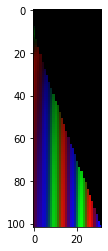

In [10]:
plt.imshow(kymo);

In [ ]:
with open('data_contSIM100k.json', 'w') as outfile:  
    json.dump(kymo, outfile)

In [ ]:
np.save("kymo50k.npy", kymo)

### Loop over kymo .py files

In [7]:
path = 'kymos/'
files = os.listdir(path)
files.sort()
files

['kymo_0.01_10000.0.npy',
 'kymo_0.03_10000.0.npy',
 'kymo_0.0_10000.0.npy',
 'kymo_0.3_10000.0.npy',
 'kymo_0.5_10000.0.npy',
 'kymo_0.7_10000.0.npy',
 'kymo_1.0_10000.0.npy',
 'kymo_1.2_10000.0.npy',
 'kymo_1.5_10000.0.npy']

In [8]:
gammas = [0.0, 0.3, 0.7, 1.0, 1.5]
ds = [10000.0]
files = []
for gamma in gammas:
    for d in ds:
        files.append(f"kymo_{gamma}_{d}.npy")

In [48]:
def reflect_kymo(kymo):
    rkymo = np.zeros([kymo.shape[0], kymo.shape[1]*2, 3])
    rkymo[:] = np.nan
    for i in range(kymo.shape[0]):
        for c in range(3):
            rkymo[i,:kymo.shape[1],c] = np.flip(kymo[i,:,c])
            rkymo[i,kymo.shape[1]:,c] = kymo[i,:,c]
    return rkymo

In [429]:
def plot_kymo(kymo, tscale, rscale, tick_step_t, tick_step_r, reflect=False):
    tick_step_t = min(tick_step_t, int(kymo.shape[0]*tscale))
    nticks = kymo.shape[0] * tscale // tick_step_t + 1
    ticks = np.arange(0, nticks) * tick_step_t / tscale
    tick_labels = np.arange(0, nticks) * tick_step_t
    tick_labels = ['%d'%label for label in tick_labels]
    plt.yticks(ticks, tick_labels)

    if reflect:
        kymo = reflect_kymo(kymo)
        lim = int(kymo.shape[1] * rscale / 2)
        left = np.flip(np.append(np.arange(0, lim, tick_step_r), lim))
        right = np.append(np.arange(0, lim, tick_step_r), lim)
        tick_labels = np.append(left, right)
        tick_labels = np.delete(tick_labels, len(tick_labels)//2)
        ticks = np.linspace(0,kymo.shape[1]-1, len(tick_labels)).astype(int).tolist()
    
    else:
        tick_step_r = min(tick_step_r, int(kymo.shape[1]*rscale))
        nticks = kymo.shape[1] * rscale // tick_step_r + 1
        ticks = np.arange(0, nticks) * tick_step_r / rscale
        tick_labels = np.arange(0, nticks) * tick_step_r
        tick_labels = ['%d'%label for label in tick_labels]
    
    plt.xticks(ticks, tick_labels)
    plt.imshow(kymo, aspect='auto')

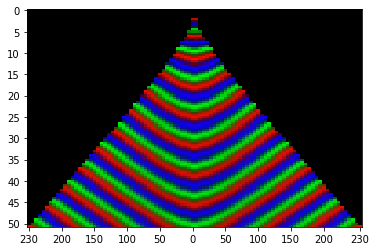

In [432]:
plot_kymo(kymo, 0.05*10, 5, 5, 50, reflect=True)

In [434]:
kymo = reflect_kymo(kymo)

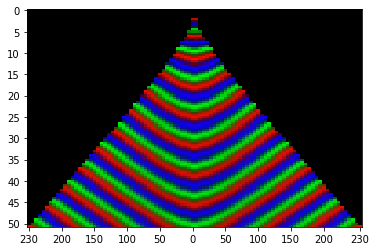

In [435]:
## plot
tscale, rscale, tick_step_t, tick_step_r = 0.05*10, 5, 5, 50

tick_step_t = min(tick_step_t, int(kymo.shape[0]*tscale))
nticks = kymo.shape[0] * tscale // tick_step_t + 1
ticks = np.arange(0, nticks) * tick_step_t / tscale
tick_labels = np.arange(0, nticks) * tick_step_t
tick_labels = ['%d'%label for label in tick_labels]
plt.yticks(ticks, tick_labels)

lim = int(kymo.shape[1] * 5 / 2)
#left = np.flip(np.append(np.arange(0, lim, tick_step_r), lim))
right = np.append(np.arange(0, lim, tick_step_r), lim)
tick_labels = np.append(left, right)
tick_labels = np.delete(tick_labels, len(tick_labels)//2)
ticks = np.linspace(0,kymo.shape[1]-1, len(tick_labels)).astype(int).tolist()
plt.xticks(ticks, tick_labels)

plt.imshow(kymo, aspect='auto');

In [412]:
int(kymo.shape[1] * 5 / 2)

230

In [398]:
left = np.flip(np.append(np.arange(0, 230, tick_step_r), 230))
right = np.append(np.arange(0, 230, tick_step_r), 230)
tick_labels = np.append(left, right)
tick_labels = np.delete(tick_labels, len(tick_labels)//2)
ticks = np.linspace(0,kymo.shape[1]+1, len(tick_labels)).astype(int).tolist()


In [397]:
len(tick_labels)

11

In [396]:
len(ticks)

11

In [436]:
files

['kymo_0.0_10000.0.npy',
 'kymo_0.3_10000.0.npy',
 'kymo_0.7_10000.0.npy',
 'kymo_1.0_10000.0.npy',
 'kymo_1.5_10000.0.npy']

file: kymo_0.0_10000.0.npy


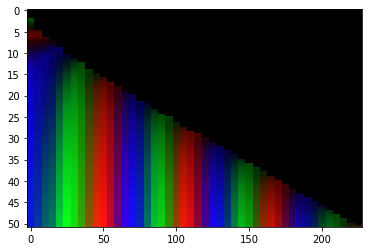

file: kymo_0.3_10000.0.npy


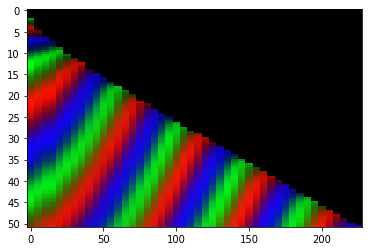

file: kymo_0.7_10000.0.npy


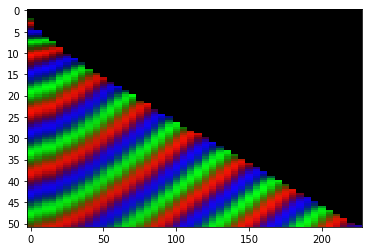

file: kymo_1.0_10000.0.npy


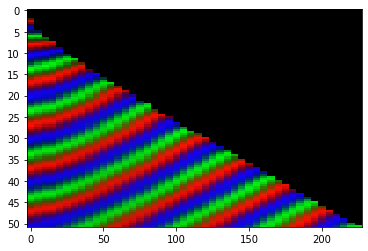

file: kymo_1.5_10000.0.npy


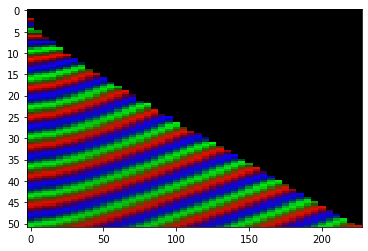

In [424]:
for file in files:
    print(f"file: {file}")
    kymo = np.load(path+file)
    plot_kymo(kymo, 0.05*10, 5, 5, 50)
    plt.show()

file: kymo_0.0_10000.0.npy


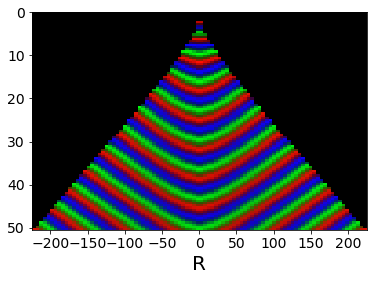

file: kymo_0.3_10000.0.npy


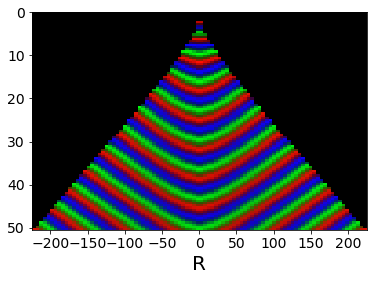

file: kymo_0.7_10000.0.npy


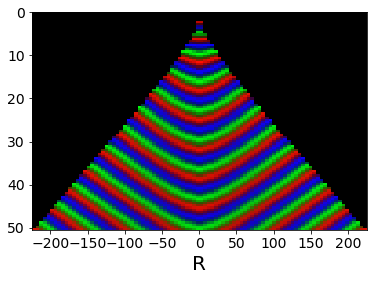

file: kymo_1.0_10000.0.npy


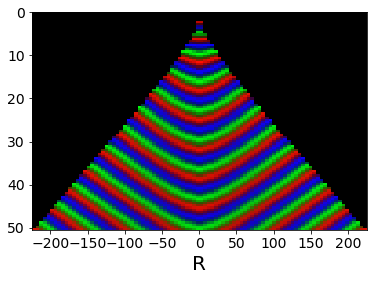

file: kymo_1.5_10000.0.npy


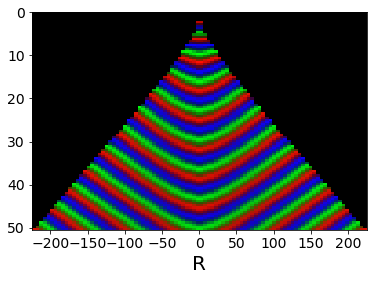

In [45]:
x_axis = np.arange(data.shape[1])*5
t_axis = np.arange(data.shape[0])*0.05*10
for file in files:
    print(f"file: {file}")
    data = np.load(path+file)
    rkymo = np.zeros([data.shape[0], data.shape[1]*2, 3])
    rkymo[:] = np.nan
    for i in range(data.shape[0]):
        for c in range(3):
            rkymo[i,:data.shape[1],c] = np.flip(kymo[i,:,c])
            rkymo[i,data.shape[1]:,c] = kymo[i,:,c]
    plt.imshow(rkymo,extent=[-x_axis.max(),x_axis.max(), t_axis.max(),t_axis.min()], aspect='auto')
    #plt.ylabel("Time", fontsize=20)
    plt.xlabel("R", fontsize=20)
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);
    plt.show()

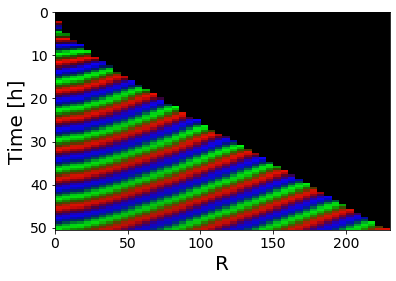

In [172]:
data = np.load(path+file)
plt.imshow(data,extent=[x_axis.min(),x_axis.max(), t_axis.max(),t_axis.min()], aspect='auto')
plt.ylabel("Time [h]", fontsize=20)
plt.xlabel("R", fontsize=20)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.show()

In [165]:
rscale = 5
xmax = data.shape[1]*rscale

x_axis = np.arange(0, xmax, 50)
t_axis = np.arange(data.shape[0])*0.05*10

In [166]:
if xmax not in x_axis:
    x_axis = np.append(x_axis, xmax)


In [167]:
x_axis

array([  0,  50, 100, 150, 200, 230])

file: kymo_0.0_10000.0.npy


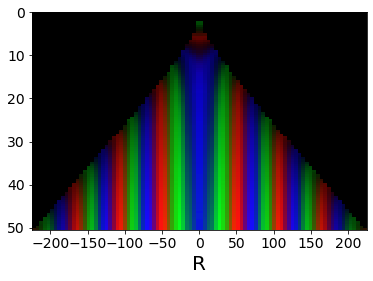

file: kymo_0.3_10000.0.npy


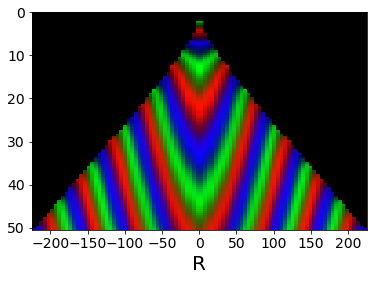

file: kymo_0.7_10000.0.npy


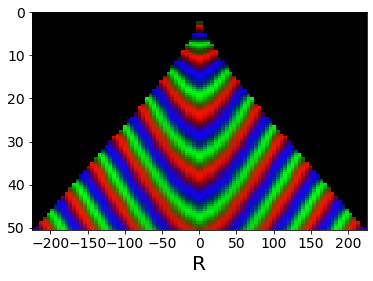

file: kymo_1.0_10000.0.npy


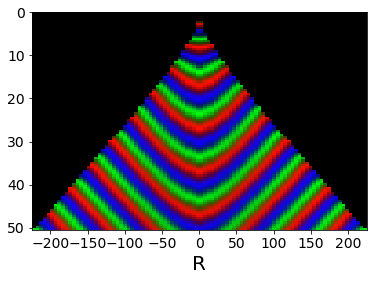

file: kymo_1.5_10000.0.npy


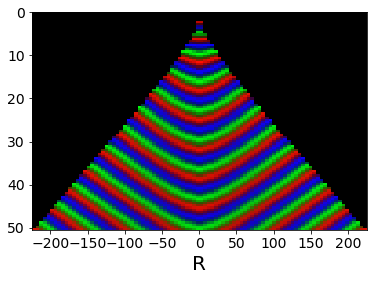

In [138]:
for file in files:
    print(f"file: {file}")
    kymo = np.load(path+file)
    rkymo = np.zeros([kymo.shape[0], kymo.shape[1]*2, 3])
    rkymo[:] = np.nan
    for i in range(data.shape[0]):
        for c in range(3):
            rkymo[i,:kymo.shape[1],c] = np.flip(kymo[i,:,c])
            rkymo[i,kymo.shape[1]:,c] = kymo[i,:,c]
    plt.imshow(rkymo,extent=[-x_axis.max(),x_axis.max(), t_axis.max(),t_axis.min()], aspect='auto')
    #plt.ylabel("Time", fontsize=20)
    plt.xlabel("R", fontsize=20)
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);
    plt.show()

In [136]:
file

'kymo_0.0_10000.0.npy'